In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.svm import SVR
from sklearn import metrics
from google.colab import drive
plt.style.use('seaborn-whitegrid')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def mape(y_true, y_pred, e=1e-10):
  y = np.concatenate([np.abs(y_true),e*np.ones(y_true.size)]).reshape(2,y_true.size)
  return np.mean(np.abs(y_true - y_pred) / np.max(y,axis=0))

Data preparing

In [ ]:
np.random.seed(1)
data1 = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/svm/avocado_prices - avocado_prices.csv').drop(['Unnamed: 0'],axis=1)
data2 = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/svm/Shanghai license plate price - Sheet3.csv')
date1 = pd.to_datetime(data1['Date'])
data1['month'] = date1.dt.month
data1['day'] = date1.dt.day

data1['type'] = data1['type'].replace(['conventional','organic'],[0,1])
countr = data1['region'].unique()
data1['region'] = data1['region'].replace(countr,np.arange(countr.size))

date2 = pd.to_datetime(data2['Date'],format='%b-%d')
data2['month'] = date2.dt.month
data2['day'] = date2.dt.day
lp = data2.columns[2]

Visualisation and preprocessing

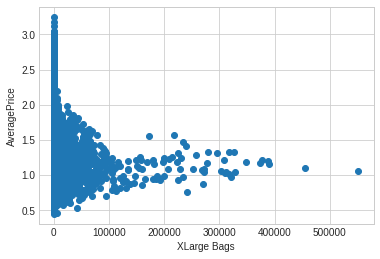

In [ ]:
def vis(data,main_atrr,secon):
  y = data[main_atrr]
  x = data[secon]
  plt.plot(x,y,'o')
  plt.xlabel(secon)
  plt.ylabel(main_atrr)

vis(data1,'AveragePrice','XLarge Bags')

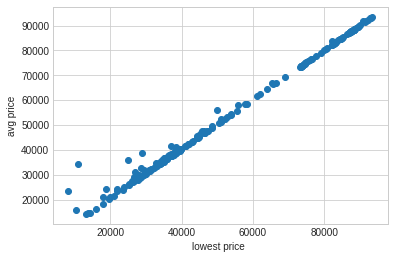

In [ ]:
vis(data2,'avg price',lp)

эту херь лучше не делай, то неё не особо много пользы и при этом может спалить

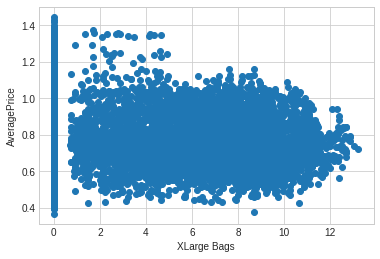

In [ ]:
l = ['AveragePrice',	'Total Volume',	'4046',	'4225',	'4770',	'Total Bags',	'Small Bags',	'Large Bags',	'XLarge Bags']
data1[l] = np.log(data1[l]+1)
vis(data1,'AveragePrice','XLarge Bags')

размещаем целевую переменную в один массив, все остальные данные формируем в двумерный массив(в первом наборе данных ещё нормализируем данные: отнимаем среднее и делим на среднее квадратическое)

In [ ]:
l = ['Total Volume',	'4046',	'4225',	'4770',	'Total Bags',	'Small Bags',	'Large Bags',	'XLarge Bags']
y1 = np.array(data1['AveragePrice'])
data1[l] = (data1[l]-data1[l].mean())/data1[l].std()
data12 = data1.copy().drop(['Date','AveragePrice'],axis=1)
X1 = np.array(data12)


y2 = np.array(data2['avg price'])
data22 = data2.copy().drop(['Date','avg price'], axis=1)
X2 = np.array(data22)

Modelling

решітчастий пошук гіперпараметрів, в списки c,e,d потрібно підставити різні значення щоб знайти оптимальні параметри

In [ ]:
#X1_train, X1_test, y1_train, y1_test = sk.model_selection.train_test_split(X1, y1, random_state=1)
c = [1000]
e = [0.01]
d = [3]
param = {'C': c ,'epsilon': e, 'degree': d }
split = sk.model_selection.KFold(shuffle=True,random_state=1,n_splits=3)
regr = SVR(kernel='poly')
grid1 = sk.model_selection.GridSearchCV(regr,param,cv=split,scoring='neg_mean_squared_error').fit(X1,y1)
#grid_1 = sk.model_selection.GridSearchCV(regr,param,cv=split).fit(X1_train,y1_train)
#regr = grid1.best_estimator_

In [ ]:
#X1_train, X1_test, y1_train, y1_test = sk.model_selection.train_test_split(X2, y2, random_state=1)
c = np.linspace(1000,7000,num=10)
e = np.linspace(1,5,num=5)
d = [1,3,2]
param = {'C': c ,'epsilon': e , 'degree': d }
split = sk.model_selection.KFold(shuffle=True,random_state=1)
regr = SVR(kernel='poly')
grid2 = sk.model_selection.GridSearchCV(regr,param,cv=split).fit(X2,y2)
#grid_2 = sk.model_selection.GridSearchCV(regr,param,cv=split).fit(X1_train,y1_train)
#regr = grid1.best_estimator_

In [ ]:
p1 = grid1.best_params_#лучшие параметры для первого набора данных
p1

{'C': 1000, 'degree': 3, 'epsilon': 0.01}

In [ ]:
p2 = grid2.best_params_#лучшие параметры для второго набора данных
p2

{'C': 7000.0, 'degree': 1, 'epsilon': 5.0}

In [ ]:
print(abs(grid1.best_score_))#лучший показатель метрики для первого набора данных

0.011925134698016496


In [ ]:
print(grid2.best_score_)#лучший показатель метрики для второго набора данных

0.9842458804125227


In [ ]:
regr.score(X1_test,y1_test)

Picture of predictions

data1


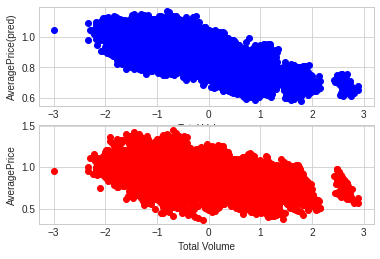

In [ ]:
y_pred = grid1.best_estimator_.predict(X1)

def vis_pr(data,secon_atrr,main_atrr,y_pred):
  fig,ax = plt.subplots(2)
  c = secon_atrr
  ax[0].plot(data[c],y_pred,'o',color='blue')
  ax[0].set_xlabel(c)
  ax[0].set_ylabel(main_atrr+'(pred)')
  ax[1].plot(data[c],data[main_atrr],'o',color='red')
  ax[1].set_xlabel(c)
  ax[1].set_ylabel(main_atrr)

print('data1')
vis_pr(data1,l[0],'AveragePrice',y_pred)

data2


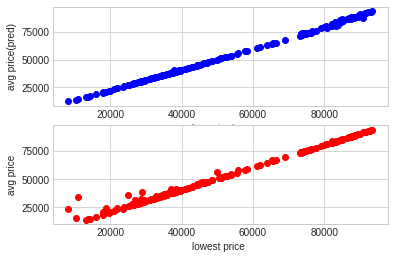

In [ ]:
print('data2')
y_pred = grid2.best_estimator_.predict(X2)
vis_pr(data2,lp,'avg price',y_pred)

Якість моделей по метрикам $ R^2 $, RMSE, MAE та MAPE :

In [ ]:
print('data1')
s={}
X1_train, X1_test, y1_train, y1_test = sk.model_selection.train_test_split(X1, y1, test_size=0.7, random_state=1)
regr1 = SVR(kernel='poly',degree=p1['degree'],C=p1['C'],epsilon=p1['epsilon']).fit(X1_train,y1_train)
y_predtr = regr1.predict(X1_train)
y_predts = regr1.predict(X1_test)
y_predtr = np.exp(y_predtr)-1
y_predts = np.exp(y_predts)-1
y1_train = np.exp(y1_train)-1
y1_test = np.exp(y1_test)-1

r2_train = metrics.r2_score(y1_train, y_predtr)
s['r2_train'] = r2_train
r2_test = metrics.r2_score(y1_test, y_predts)
s['r2_test'] = r2_test
rmse_train = metrics.mean_squared_error(y1_train, y_predtr)
s['rmse_train'] = rmse_train
rmse_test = metrics.mean_squared_error(y1_test, y_predts)
s['rmse_test'] = rmse_test
mae_train = metrics.mean_absolute_error(y1_train, y_predtr)
s['mae_train'] = mae_train
mae_test = metrics.mean_absolute_error(y1_test, y_predts)
s['mae_test'] = mae_test
mape_train = mape(y1_train, y_predtr)
s['mape_train'] = mape_train
mape_test = mape(y1_test, y_predts)
s['mape_test'] = mape_test

for i in s.keys():
  print(i+'='+str(s[i]))


data1
r2_train=0.5398819629823646
r2_test=0.542833519979796
rmse_train=0.07383155478978635
rmse_test=0.07444692095267276
mae_train=0.2096375660778228
mae_test=0.21074091060919886
mape_train=0.15870646360091425
mape_test=0.15860647146590467


In [ ]:
print('data2')
s={}
X2_train, X2_test, y2_train, y2_test = sk.model_selection.train_test_split(X2, y2, test_size=0.4, random_state=1)
regr2 = SVR(kernel='poly',degree=p2['degree'],C=p2['C'],epsilon=p2['epsilon']).fit(X2_train,y2_train)
y_predtr = regr2.predict(X2_train)
y_predts = regr2.predict(X2_test)

r2_train = metrics.r2_score(y2_train, y_predtr)
s['r2_train'] = r2_train
r2_test = metrics.r2_score(y2_test, y_predts)
s['r2_test'] = r2_test
rmse_train = metrics.mean_squared_error(y2_train, y_predtr)
s['rmse_train'] = rmse_train
rmse_test = metrics.mean_squared_error(y2_test, y_predts)
s['rmse_test'] = rmse_test
mae_train = metrics.mean_absolute_error(y2_train, y_predtr)
s['mae_train'] = mae_train
mae_test = metrics.mean_absolute_error(y2_test, y_predts)
s['mae_test'] = mae_test
mape_train = mape(y2_train, y_predtr)
s['mape_train'] = mape_train
mape_test = mape(y2_test, y_predts)
s['mape_test'] = mape_test

for i in s.keys():
  print(i+'='+str(s[i]))

data2
r2_train=0.9852485425125882
r2_test=0.9862259030252686
rmse_train=8666928.607022662
rmse_test=7227886.558404209
mae_train=2142.777743528703
mae_test=1705.4726650567382
mape_train=0.05283398970886738
mape_test=0.040953584413755496


In [ ]:
y2.var()

562364099.6696222

рахуємо опорні вектори

In [ ]:
print('Support vectors for data1:')
print('n_vectors = '+str(regr1.support_vectors_.shape[0]))
print(regr1.support_vectors_)
print('Support vectors for data2:')
print('n_vectors = '+str(regr2.support_vectors_.shape[0]))
print(regr2.support_vectors_)

Conclusion :
Перша модель регресії методом опорних векторів добре мінімузує
метрику mean_squared_error, а друга - r2_score, тобто в першому випадку похибка прогнозів відносно дисперсії вибірки досить велика, хоча абсолютне значення цієї похбки, частково через досить малу дисперсію, невелике, в другому випадку навпаки - дуже велика дисперсія вибірки і гарно мінімізується коефіцієнт детермінації. В принципі в обох наборах даних модель гарно відчуває характер цільової змінної, тобто якщо зростає(спадає) цільова змінна, то теж саме відбувається і з передбаченнями.
В першому випадку розмір навчальної вибірки особливо не впливає на якість моделі,хіба що він буде дуже маленький(<20%), в другому - дещо схожа ситуація, однак там модель все ж більш чутлива до розміру навчальної вибірки(якщо він <35%, то якість моделі сильно падає, можливо це тому що сам набір даних є досить невеликим).